In [26]:
import cv2
import matplotlib.pyplot as plt 
import torch
import numpy as np
from ultralytics import YOLO
from segment_anything import sam_model_registry, SamPredictor

In [ ]:
# Load pretrained YOLOv8 face detection model
model = YOLO("yolov11n-face.pt")
  
# Load SAM segmentation model
sam_checkpoint = r"sam_vit_b_01ec64.pth" # change this to your path
"""
vit_b: SAM base model
vit_h: SAM huge model
You can download SAM models from this link --> https://huggingface.co/datasets/Gourieff/ReActor/blob/main/models/sams/sam_vit_b_01ec64.pth
"""
model_type = "vit_b"
 
# check if CUDA is available and set device accordingly
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
 
# load SAM model to the GPU
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
 
# Create SAM predictor instance
predictor = SamPredictor(sam)

Using device: cuda


0: 480x640 2 faces, 22.0ms
Speed: 3.0ms preprocess, 22.0ms inference, 9.0ms postprocess per image at shape (1, 3, 480, 640)


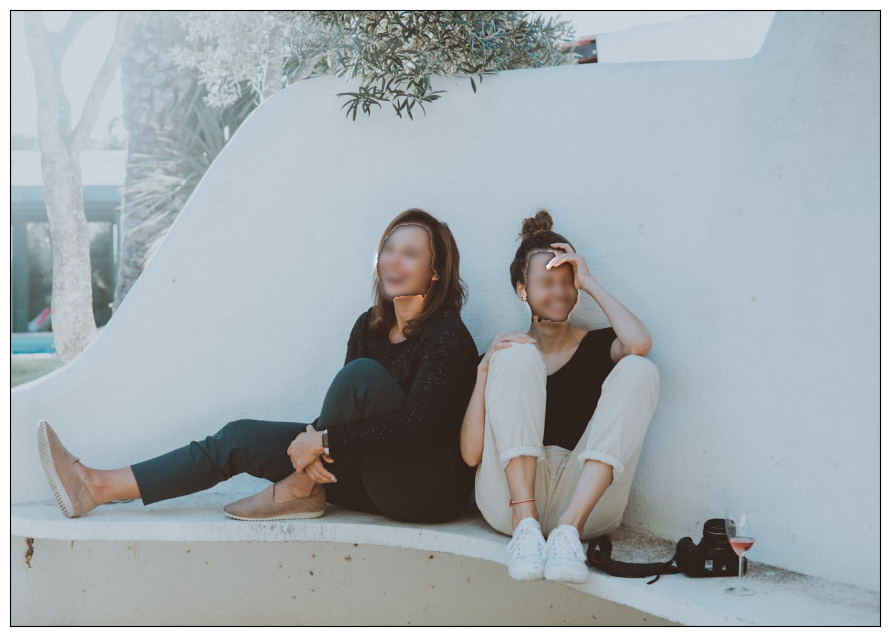

In [30]:
# Load the image
image_path = "images/friends1.jpg"  # Change this to your image file
image = cv2.imread(image_path)
  
# Run YOLO face detection model on full image
results = model(image)[0]
  
# Loop over each detected face and segment it
for box in results.boxes.xyxy:
    predictor.set_image(image)
    x1, y1, x2, y2 = map(int, box)
    input_box = np.array([[x1, y1, x2, y2]])
 
    # Run SAM segmentation model
    masks, _, _ = predictor.predict(box=input_box, multimask_output=False)
  
    # Create the mask for the segmented face
    mask = masks[0].astype(np.uint8) * 255
  
    # Blur the face region (Gaussian blur)
    face_region = cv2.bitwise_and(image, image, mask=mask)
    blurred_face = cv2.GaussianBlur(face_region, (25, 25), 0)
  
    # Replace the original face region with the blurred face
    face_removed_image = cv2.bitwise_and(image, image, mask=cv2.bitwise_not(mask))  # Keep the non-masked areas
    image = cv2.add(face_removed_image, blurred_face)  # Add the blurred face to the original image
  
 
# show result
plt.figure(figsize=(15, 8))
plt.xticks([]), plt.yticks([])
plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))

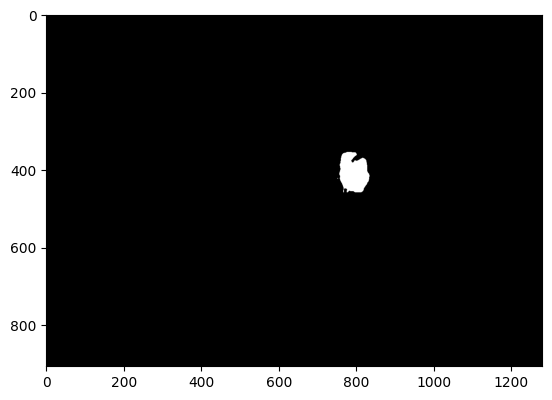

In [32]:
plt.imshow(mask,cmap="gray")

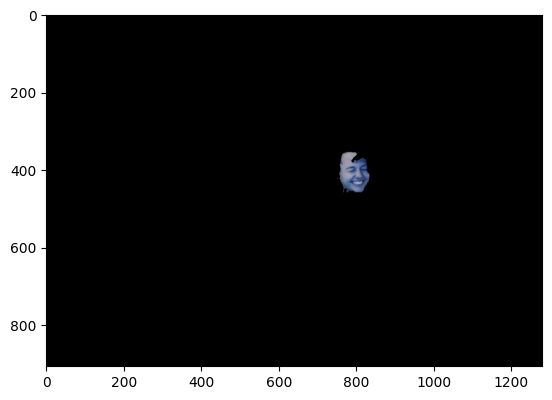

In [33]:
plt.imshow(face_region)

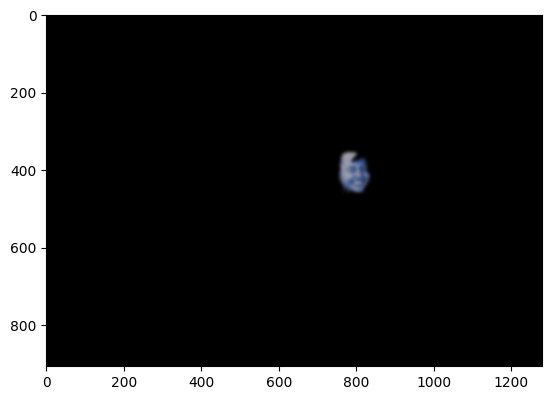

In [34]:
plt.imshow(blurred_face)

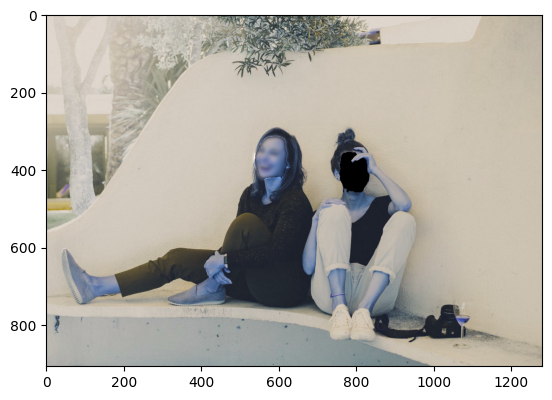

In [35]:
plt.imshow(face_removed_image)

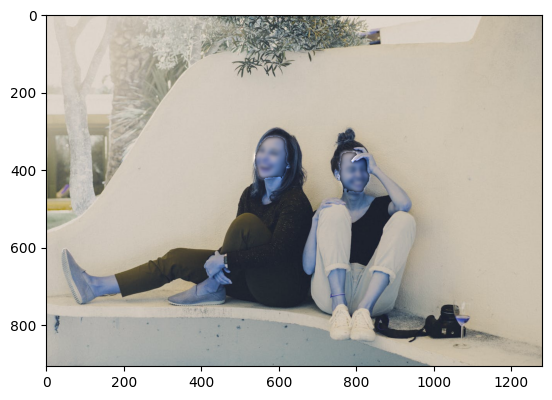

In [36]:
plt.imshow(image)